## Part III: feature engineering

#### In this section, we will pre-processing the review data and perform feature engineering for the rating model development. Because there are totally 916 conditions covered in this set, we will select the top 3 of them as our study dataset, birth control, pain and depression. 

### 3.1 data pre-processing

In [62]:
import re
import nltk
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
df=pd.read_csv('data/df_EDA.csv', index_col=0)
df.head(3)

,drugName,condition,review,rating,date,usefulCount,year,month,weekday,clean_re,sent_len,word_len
163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22,2012,2,1,ve antidepressants years citalopram fluoxetine...,4,81
206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,2009-05-17,17,2009,5,6,son crohn disease asacol complaints show side ...,4,55
159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,2017-09-29,3,2017,9,4,quick reduction symptoms,1,6


In [64]:
#We need different text preprocessing for feature engineering, so we delete the previous one, clean_re
#From section 2, we found sent_len is not informative as word_len. Thus we delete it from the data set and use word_len to evaluate the length of the review.
df1=df.drop(['clean_re', 'sent_len'], axis=1)
df1=df1[df1.condition.isin(['Birth Control', 'Depression', 'Pain'])]

In [65]:
print('The original data set dimension is ' + str(df.shape).strip('()'))
print('The dimension of the reduced data set exclusively for the top 3 conditions is '+ str(df1.shape).strip('()'))

The original data set dimension is 213869, 12
The dimension of the reduced data set exclusively for the top 3 conditions is 58845, 10


<AxesSubplot:>

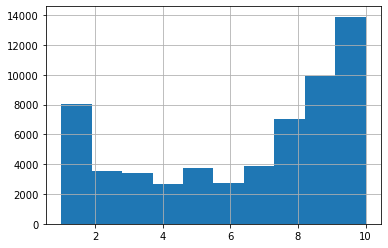

In [66]:
df1.rating.hist()

The rating of these reviews is not evenly distributed. Most revews have high rating 8~10 

## 3.2 feature engineering

### 3.2.1 use NLTK pre-trained sentiment analyzer, VADER, to get the sentiment indicator as predictor

NLTK has a built-in sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).We can use it to extract the sentiment information in the review

In [67]:
#Using NLTK’s Pre-Trained Sentiment Analyzer, VADER (Valence Aware Dictionary and sEntiment Reasoner)
import nltk
nltk.download(["vader_lexicon"])
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gln_d\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [68]:
#Let's test dis_analyzer using nltk.sentiment.vader
df1.review.iloc[0]

'"I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me."'

In [69]:
sid_analyzer.polarity_scores(df1.review.iloc[0])

{'neg': 0.212, 'neu': 0.61, 'pos': 0.178, 'compound': -0.4596}

In [70]:
#use compound score as sentiment indicator
def sentiment_vader(review):
    c=sid_analyzer.polarity_scores(review).get('compound')
    return c   

In [71]:
sentiment_vader(df1.review.iloc[1])

0.9559

In [72]:
df1['vader_compound']=[sentiment_vader(i) for i in df1.review]

In [73]:
df1.head()

,drugName,condition,review,rating,date,usefulCount,year,month,weekday,word_len,vader_compound
163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22,2012,2,1,81,-0.4596
97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4,2015,10,3,157,0.9559
215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6.0,2016-06-06,1,2016,6,0,114,-0.5998
71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2.0,2011-04-16,3,2011,4,5,101,-0.8901
79865,Blisovi Fe 1 / 20,Birth Control,"""I absolutely love this product and recommend ...",10.0,2017-11-03,4,2017,11,4,95,0.4468


### 3.2.2 use textblob pre-trained sentiment analyzer, TextBlob, to extract sentiment information as candidate features

Polarity is float which lies in the range of [-1,1]. where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]. The detail can be found https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/

In [74]:
from textblob import TextBlob
blob = TextBlob("This restaurant was great, but I'm not sure if I'll go there again.")
blob.sentiment

Sentiment(polarity=0.275, subjectivity=0.8194444444444444)

In [75]:
blob.sentiment.polarity

0.275

In [76]:
df1['textblob_polarity']=[TextBlob(i).sentiment.polarity for i in df1.review]

In [77]:
df1['textblob_subjectivity']=[TextBlob(i).sentiment.subjectivity for i in df1.review]

### 3.2.3 importance of the features
Let's check the trends of rating with the other predictors first and get a general idea about their correlations. It is different from the previously calculating corr. We will use the average or median of the predictors or rating to do the evaluation.

<AxesSubplot:xlabel='rating', ylabel='vader_compound'>

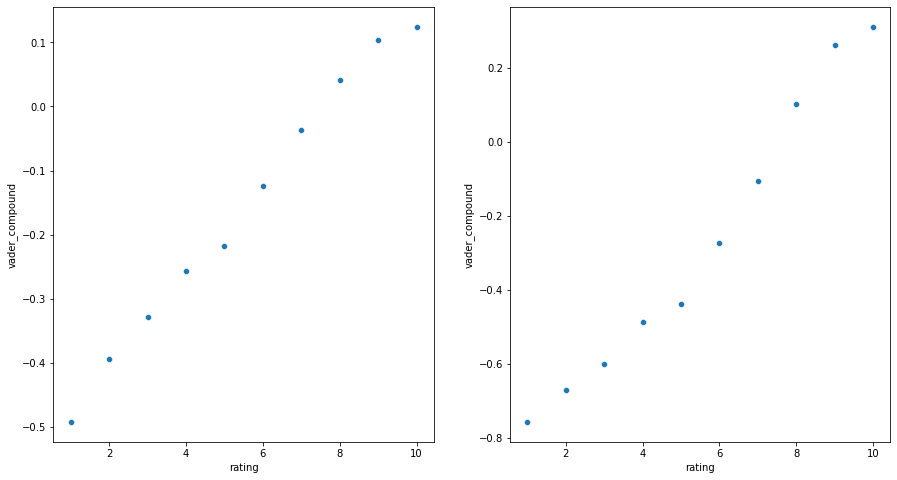

In [78]:
va_rating_mean=df1.groupby('rating').vader_compound.mean()
va_rating_median=df1.groupby('rating').vader_compound.median()
f, (ax1, ax2)=plt.subplots(1,2,figsize=(15, 8), sharex=True)
sns.scatterplot(data=va_rating_mean.reset_index(), x='rating', y='vader_compound', ax=ax1)
sns.scatterplot(data=va_rating_median.reset_index(), x='rating', y='vader_compound', ax=ax2)

<AxesSubplot:xlabel='rating', ylabel='textblob_polarity'>

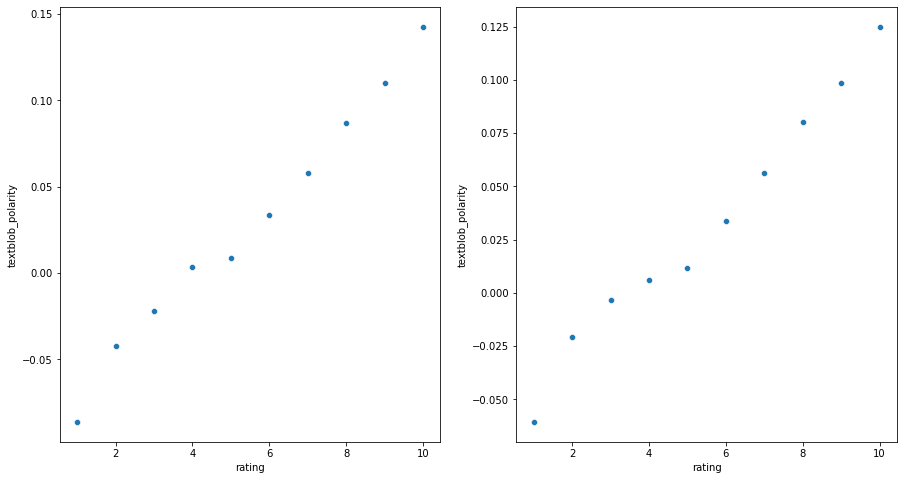

In [79]:
po_rating_mean=df1.groupby('rating').textblob_polarity.mean()
po_rating_median=df1.groupby('rating').textblob_polarity.median()
f, (ax1, ax2)=plt.subplots(1,2,figsize=(15, 8), sharex=True)
sns.scatterplot(data=po_rating_mean.reset_index(), x='rating', y='textblob_polarity', ax=ax1)
sns.scatterplot(data=po_rating_median.reset_index(), x='rating', y='textblob_polarity', ax=ax2)

<AxesSubplot:xlabel='rating', ylabel='textblob_subjectivity'>

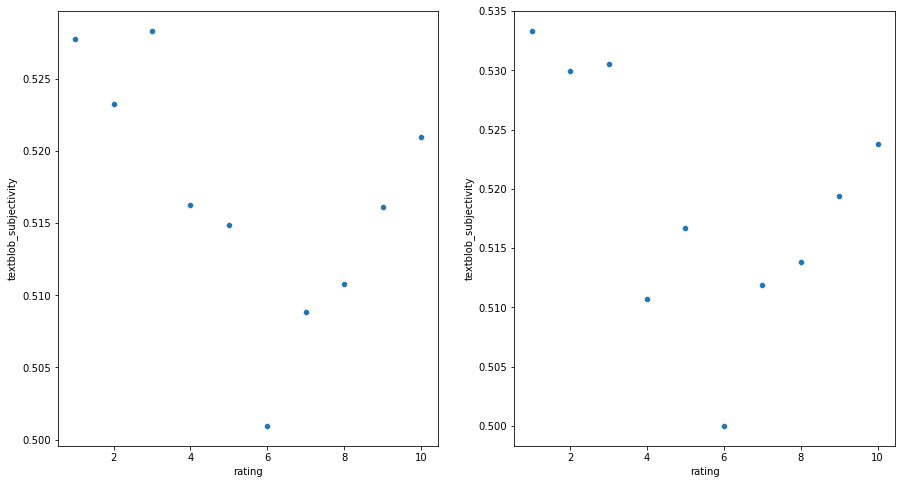

In [80]:
sub_rating_mean=df1.groupby('rating').textblob_subjectivity.mean()
sub_rating_median=df1.groupby('rating').textblob_subjectivity.median()
f, (ax1, ax2)=plt.subplots(1,2,figsize=(15, 8), sharex=True)
sns.scatterplot(data=sub_rating_mean.reset_index(), x='rating', y='textblob_subjectivity', ax=ax1)
sns.scatterplot(data=sub_rating_median.reset_index(), x='rating', y='textblob_subjectivity', ax=ax2)

<AxesSubplot:xlabel='rating', ylabel='usefulCount'>

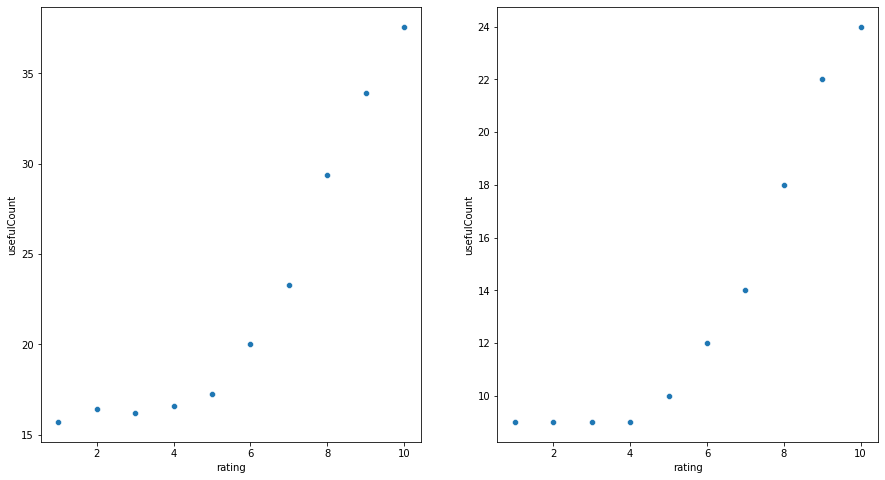

In [81]:
f, (ax1, ax2)=plt.subplots(1,2,figsize=(15, 8), sharex=True)
sns.scatterplot(data=df.groupby('rating').usefulCount.mean().reset_index(), x='rating', y='usefulCount', ax=ax1)
sns.scatterplot(data=df.groupby('rating').usefulCount.median().reset_index(), x='rating', y='usefulCount', ax=ax2)

<AxesSubplot:xlabel='year', ylabel='rating'>

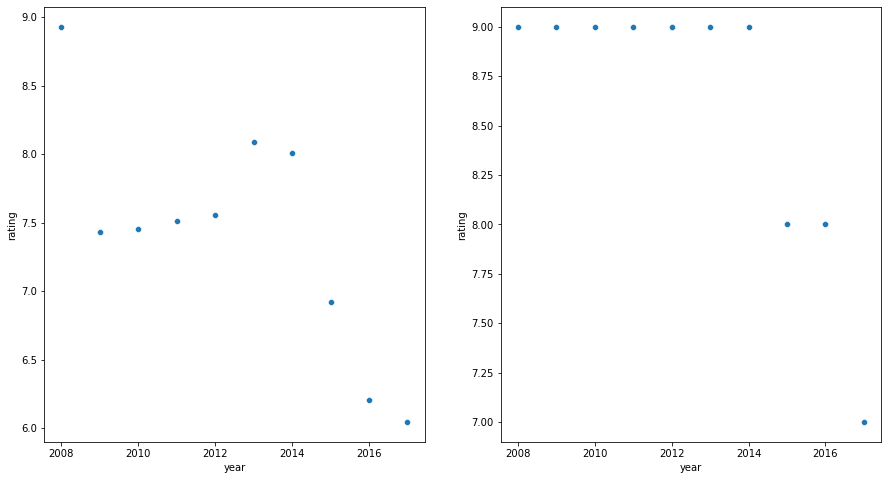

In [82]:
f, (ax1, ax2)=plt.subplots(1,2,figsize=(15, 8), sharex=True)
sns.scatterplot(data=df.groupby('year').rating.mean().reset_index(), x='year', y='rating', ax=ax1)
sns.scatterplot(data=df.groupby('year').rating.median().reset_index(), x='year', y='rating', ax=ax2)

<AxesSubplot:xlabel='month', ylabel='rating'>

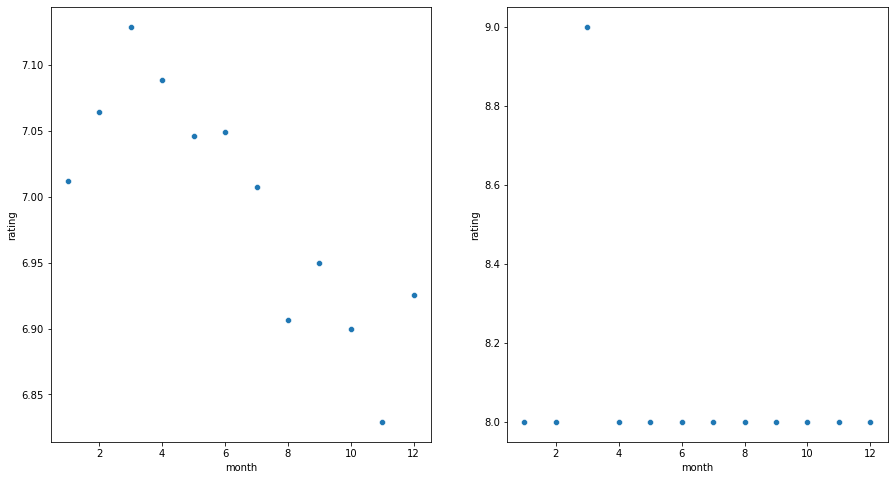

In [83]:
f, (ax1, ax2)=plt.subplots(1,2,figsize=(15, 8), sharex=True)
sns.scatterplot(data=df.groupby('month').rating.mean().reset_index(), x='month', y='rating', ax=ax1)
sns.scatterplot(data=df.groupby('month').rating.median().reset_index(), x='month', y='rating', ax=ax2)

<AxesSubplot:xlabel='weekday', ylabel='rating'>

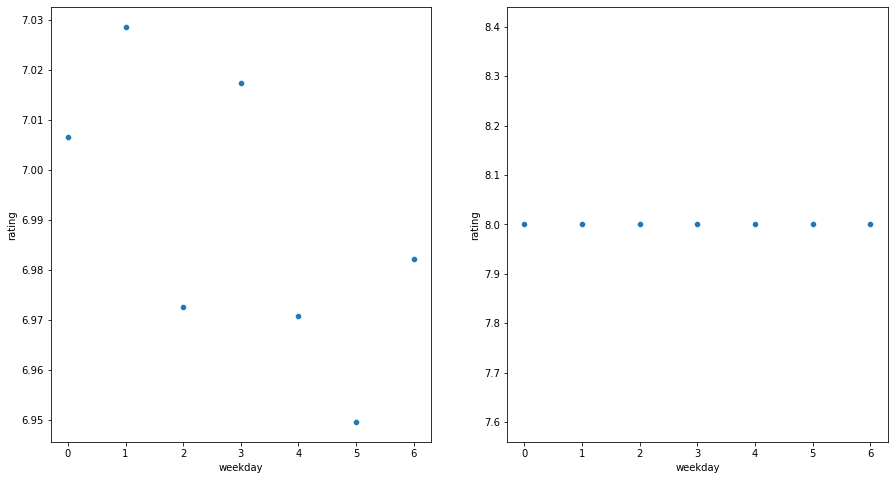

In [84]:
f, (ax1, ax2)=plt.subplots(1,2,figsize=(15, 8), sharex=True)
sns.scatterplot(data=df.groupby('weekday').rating.mean().reset_index(), x='weekday', y='rating', ax=ax1)
sns.scatterplot(data=df.groupby('weekday').rating.median().reset_index(), x='weekday', y='rating', ax=ax2)

<AxesSubplot:xlabel='rating', ylabel='word_len'>

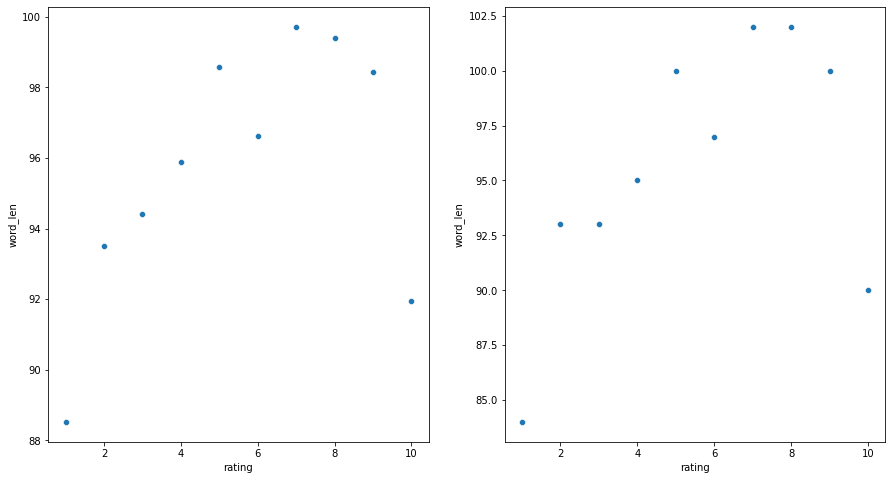

In [85]:
f, (ax1, ax2)=plt.subplots(1,2,figsize=(15, 8), sharex=True)
sns.scatterplot(data=df.groupby('rating').word_len.mean().reset_index(), x='rating', y='word_len', ax=ax1)
sns.scatterplot(data=df.groupby('rating').word_len.median().reset_index(), x='rating', y='word_len', ax=ax2)

Well, the scatter plot gave us miscellaneous trends. We found the obvious positive correlations between rating with three predictors, vader_compound, textblob_polarity, and usefulCount. As for the other features, their plot are complicated. That's why We decided to keep all of them in the model at this step temporarily.

### 3.2.4 dataset split for training and testing

In [86]:
#convert categorical variables into dummy variables
df1.drugName.nunique()

507

In [87]:
y=df1.rating
X=df1.drop(columns=['date', 'rating', 'drugName'])

In [88]:
X.head()

,condition,review,usefulCount,year,month,weekday,word_len,vader_compound,textblob_polarity,textblob_subjectivity
163740,Depression,"""I&#039;ve tried a few antidepressants over th...",22,2012,2,1,81,-0.4596,0.000000,0.440000
97768,Birth Control,"""I have been on this birth control for one cyc...",4,2015,10,3,157,0.9559,0.260926,0.550463
215892,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",1,2016,6,0,114,-0.5998,-0.110663,0.618027
71428,Birth Control,"""I was on this pill for almost two years. It d...",3,2011,4,5,101,-0.8901,-0.005889,0.546889
79865,Birth Control,"""I absolutely love this product and recommend ...",4,2017,11,4,95,0.4468,0.071667,0.578333


In [89]:
#convert 'condition' into dummy variable
con_dummy=pd.get_dummies(X.condition, drop_first=True)
con_dummy.rename(columns={'Depression':'con_1', 'Pain':'con_2'}, inplace=True)
X=pd.concat([X, con_dummy], axis=1)
X.head()

,condition,review,usefulCount,year,month,weekday,word_len,vader_compound,textblob_polarity,textblob_subjectivity,con_1,con_2
163740,Depression,"""I&#039;ve tried a few antidepressants over th...",22,2012,2,1,81,-0.4596,0.000000,0.440000,1,0
97768,Birth Control,"""I have been on this birth control for one cyc...",4,2015,10,3,157,0.9559,0.260926,0.550463,0,0
215892,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",1,2016,6,0,114,-0.5998,-0.110663,0.618027,0,0
71428,Birth Control,"""I was on this pill for almost two years. It d...",3,2011,4,5,101,-0.8901,-0.005889,0.546889,0,0
79865,Birth Control,"""I absolutely love this product and recommend ...",4,2017,11,4,95,0.4468,0.071667,0.578333,0,0


In [90]:
X=X.drop(columns=['condition'])
#depression if con_1=1, pain if con_2=1, birth control if con_1 and con_2 both =0
X.head()

,review,usefulCount,year,month,weekday,word_len,vader_compound,textblob_polarity,textblob_subjectivity,con_1,con_2
163740,"""I&#039;ve tried a few antidepressants over th...",22,2012,2,1,81,-0.4596,0.000000,0.440000,1,0
97768,"""I have been on this birth control for one cyc...",4,2015,10,3,157,0.9559,0.260926,0.550463,0,0
215892,"""I&#039;ve had the copper coil for about 3 mon...",1,2016,6,0,114,-0.5998,-0.110663,0.618027,0,0
71428,"""I was on this pill for almost two years. It d...",3,2011,4,5,101,-0.8901,-0.005889,0.546889,0,0
79865,"""I absolutely love this product and recommend ...",4,2017,11,4,95,0.4468,0.071667,0.578333,0,0


In [91]:
X.dtypes

review                    object
usefulCount                int64
year                       int64
month                      int64
weekday                    int64
word_len                   int64
vader_compound           float64
textblob_polarity        float64
textblob_subjectivity    float64
con_1                      uint8
con_2                      uint8
dtype: object

In [92]:
X.isna().sum()

review                   0
usefulCount              0
year                     0
month                    0
weekday                  0
word_len                 0
vader_compound           0
textblob_polarity        0
textblob_subjectivity    0
con_1                    0
con_2                    0
dtype: int64

In [93]:
#we will use the same stopwords for text data normalization as in EDA analysis
import requests
url = 'http://members.unine.ch/jacques.savoy/clef/englishST.txt'
r = requests.get(url)
with open('./data/englishST.txt', 'wb') as f:
    f.write(r.content)
stop_words = []
with open('data/englishST.txt', 'r') as f:
    [stop_words.append(word) for line in f for word in line.split()]
stopwords=set(stop_words)
len(stopwords)

570

In [94]:
stopwords_update=stopwords|{'ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'}

In [95]:
#we need clean the review for LSA analysis
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()
def clean_review_LSA(review):
    review_text = BeautifulSoup(review, 'html.parser').get_text() #remove html tags
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text) #substitute all non-letter symbols with space
    words = letters_only.lower().split() #convert all element in the string into lower case
    useful_w=[w for w in words if not w in stopwords_update] #remove the most common stop words
    long_w=[w for w in useful_w if len(w) > 2] # remove the short words with length <=2
    stemmed_tokens = [p_stemmer.stem(i) for i in long_w]
    return( ' '.join(stemmed_tokens)) #join stemmed token use space 

In [96]:
X['clean_review_LSA'] = [clean_review_LSA(i) for i in X.review]
X.clean_review_LSA[:2]#check the results

163740    antidepress year citalopram fluoxetin amitript...
97768     birth control cycl read review type similar bi...
Name: clean_review_LSA, dtype: object

In [97]:
X=X.drop(columns=['review'])

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [119]:
y_train.shape

(41191,)

### 3.2.5 TfidfVectorizer transform review data and use it directly as X for modeling development. 
The corresponding data set is tfidf_train_df, tfidf_test_df. There are totally 288 predictors

In [99]:
X_train.head(5)

,usefulCount,year,month,weekday,word_len,vader_compound,textblob_polarity,textblob_subjectivity,con_1,con_2,clean_review_LSA
168161,18,2012,5,3,159,-0.6610,0.159259,0.415741,0,0,jolessa year placebo pill period year doctor o...
226229,0,2015,9,6,106,0.9460,0.292857,0.642857,0,0,pretti iffi implant juli heal perfectli coupl ...
124826,2,2015,11,2,87,0.4465,-0.000417,0.493333,0,0,brand horribl side effect pill work thought fi...
62295,44,2013,1,6,97,0.9423,0.125000,0.550758,1,0,day felt relax yawn day woke promptli hour sle...
192400,13,2015,1,6,171,0.6052,0.004512,0.433097,0,0,ya year ago stop problem clear acn mild start ...


In [100]:
X_train.shape

(41191, 11)

In [101]:
#How to select the best parameter for TfidfVectorizer?
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(max_df = 0.9, min_df = 0.02, smooth_idf=True, ngram_range=(1,2)) #add ngram 2 becasue bigram did give us more information about customer experience from section 2
X_train_tfidf = vec.fit_transform(X_train['clean_review_LSA'])
X_train_tfidf.shape

(41191, 288)

In [102]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

In [103]:
tfidf_train_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vec.get_feature_names(), index=X_train.index)

In [104]:
tfidf_train_df.head()

,absolut,acn,activ,adjust,affect,ago,amaz,antidepress,anxieti,anymor,...,wonder,work,work great,worri,wors,worst,worth,year,year ago,zoloft
168161,0.0,0.164172,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.557675,0.000000,0.0
226229,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
124826,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.154974,0.0,0.0,0.0,0.0,0.255881,0.000000,0.000000,0.0
62295,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.196509,0.0,0.0,0.0,0.0,0.000000,0.161499,0.000000,0.0
192400,0.0,0.127561,0.0,0.0,0.0,0.13653,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.086662,0.188945,0.0


In [105]:
X_test_tfidf=vec.transform(X_test['clean_review_LSA'])
tfidf_test_df = pd.DataFrame(X_test_tfidf.toarray(), columns=vec.get_feature_names(), index=X_test.index)

In [106]:
#Combine predictors in X with the tfidf extracted features as the predictor
tfidf_train_X=pd.concat([X_train.drop(columns=['clean_review_LSA']),tfidf_train_df], axis=1)
tfidf_test_X=pd.concat([X_test.drop(columns=['clean_review_LSA']),tfidf_test_df], axis=1)

In [107]:
tfidf_train_X.shape

(41191, 298)

In [108]:
tfidf_test_X.shape

(17654, 298)

In [109]:
tfidf_train_X.isnull().sum()

usefulCount    0
year           0
month          0
weekday        0
word_len       0
              ..
worst          0
worth          0
year           0
year ago       0
zoloft         0
Length: 298, dtype: int64

### 3.2.6  use Latent sematic analysis (LSA) to extract information from the review as features for modeling

Generally speaking, topic modeling is a text mining technique identifying keywords to summarize large collections of textual information. It helps in discovering hidden topics in the document, and organize the unstructured text data. In this project, we are going to apply it as a feature generator.

In the following steps, we will do dimension reduction using truncated SVD (aka LSA). It performs linear dimension reduction in a different way of PCA. It does not center the data before computing the singular value decomposition, which means it can work on sparse matrices efficiently.

In [110]:
# Here we will extract 100 componets for experiment because it can explain more than 60% of original variance in the review data
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=100, random_state=42)
svd_model.fit(tfidf_train_df)
svd_model.explained_variance_ratio_.sum()

0.6239055405476756

In [111]:
tfidf_lsa_train = svd_model.fit_transform(tfidf_train_df)
tfidf_lsa_test = svd_model.transform(tfidf_test_df)

In [112]:
type(tfidf_lsa_train)

numpy.ndarray

In [113]:
tfidf_lsa_train_df = pd.DataFrame(tfidf_lsa_train, columns=['component '+str(i) for i in range(100)], index=X_train.index)
tfidf_lsa_test_df = pd.DataFrame(tfidf_lsa_test, columns=['component '+str(i) for i in range(100)], index=X_test.index)                                  

In [114]:
#Combine predictors in X with the lsa extracted features as the predictor
tfidf_lsa_train_X=pd.concat([X_train.drop(columns=['clean_review_LSA']),tfidf_lsa_train_df], axis=1)
tfidf_lsa_test_X=pd.concat([X_test.drop(columns=['clean_review_LSA']),tfidf_lsa_test_df], axis=1)

In [115]:
tfidf_lsa_train_X.shape

(41191, 110)

In [116]:
tfidf_lsa_test_X.shape

(17654, 110)

### 3.2.7 export data for modelling

<AxesSubplot:>

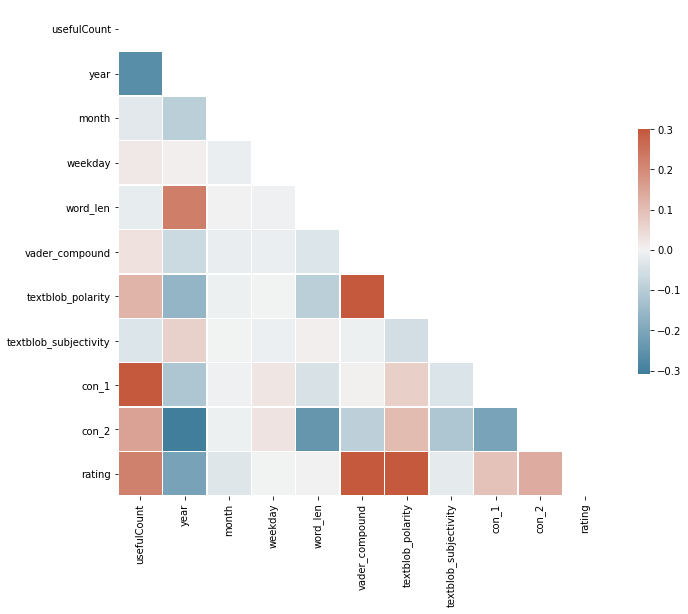

In [117]:
#let's check the correlation between predictors
import seaborn as sns
corr=pd.concat([X.drop(columns=['clean_review_LSA']), y], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
#There is no obvious correlation between features in this study

In [120]:
tfidf_lsa_test_X.to_csv('data/tfidf_lsa_test_X.csv', index=False)
tfidf_lsa_train_X.to_csv('data/tfidf_lsa_train_X.csv', index=False)
tfidf_train_X.to_csv('data/tfidf_train_X.csv', index=False)
tfidf_test_X.to_csv('data/tfidf_test_X.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)